In [170]:
# default_exp hypothesis_testing

# Hypothesis testing
> How to practically compare aspects of two distributions

In [171]:
#hide
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
#export
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import stats
import pandas as pd

from thinkstats import basic_stats
from thinkstats import nsfg

In [173]:
#hide
mpl.style.use("bmh")

**Basic steps for the investigation**
1. calc *test statistic*: e.g. coin of interest is biased ($p \ne 0.5$)
2. define *null hypothesis*: e.g. if the coin were unbiased / fair we would have $p = 0.5$)
3. compute the *p-value*

The core of the p-value is to estimate how probable an aspect of an observed dataset is. The aspect is the *test statistic*, like the mean occurrences of heads in a series of coin tosses. To retrieve the p-value we compute the test statistic for the observed dataset and for a lot of perturbed version of the dataset. Then we can quantify how rare the value for the test statistic we calculated for the observed, unperturbed, dataset really is.

What I find needs a bit of getting used to is to figure out how to perturb the dataset properly. To apply this to various practical situations one may need quite a bit of experience. In the first example below we want to verify if two coins deviate from oneanother in their fairness. So our test statistic is the difference of the share of obtained heads. We define our hypothesis as: the two coins are equally fair. To verify this we perturb our dataset of the coin tosses of both coins by repeatedly, `n_test` times, mixing their results up and computing the test statistic. We do this because of both coins are equally fair the mixing up shouldn't matter. This way we can gauge where in the distribution of the test statistic for the mixed up datasets the test statistic of the original dataset lies. If we want to know how much more biased towards heads coin 1 is than coin 0 we only need to compute the cumulative density function over the test statistics from the mixups and find the probability (left tail only) for the test statistic of the original dataset. If we want to know about general deviation in fairness we need to consider both sides of the distribution of the test statistics from the mixups.

## Synthetic data

### Discrete - Bernoulli $p$

Defining generative distributions for population 0 and 1

In [174]:
pop0_gen = stats.bernoulli(p=.5)
pop1_gen = stats.bernoulli(p=.7)

Number of samples to generate for each population

In [175]:
n0 = 100
n1 = 120

Generating the populations

In [176]:
samples0 = pop0_gen.rvs(size=n0)
samples1 = pop1_gen.rvs(size=n0)
samples0[:5], samples1[:5]

(array([0, 1, 1, 0, 1]), array([0, 1, 1, 0, 1]))

We claim (hypothesis) the two coins `pop0_gen` and `pop1_gen` do not deviate from each other in their fairness → test statistic is the difference of their means

In [177]:
#export
def get_mean_test_statistic(a:np.ndarray, b: np.ndarray) -> float: return a.mean() - b.mean()

In [178]:
test_statistic = get_mean_test_statistic(samples0, samples1); test_statistic

-0.22999999999999998

To compute the p-value we need to compute the distribution of bootstrapped distributions and their test statistics. `n_tests` defines the number of bootstrappings to perform

In [179]:
n_tests = 1000

In [180]:
# export
def get_boot_test_statistics(a:np.ndarray, b: np.ndarray, n_tests:int=100, 
                             test_statistic_fun:callable=get_mean_test_statistic,
                             mode="merge+shuffle"):
    "Computes bootstrapped test statistics using shuffling"
    test_statistic_boot = np.zeros(n_tests)
    if mode == "merge+shuffle":
        samples = np.hstack((a, b))
        n = len(a)
        for i in range(n_tests):
            np.random.shuffle(samples)
            _a, _b = samples[:n], samples[n:]
            test_statistic_boot[i] = test_statistic_fun(_a, _b)
    elif mode == "shuffle":
        for i in range(n_tests):
            _a, _b = np.random.choice(a, size=len(a)), np.random.choice(b, size=len(b))
            test_statistic_boot[i] = test_statistic_fun(_a, _b)
    else:
        raise NotImplementedError("`mode` needs to be 'merge+shuffle' or 'shuffle'.")
    return test_statistic_boot

In [181]:
%%time
test_statistic_boot = get_boot_test_statistics(samples0, samples1, n_tests=n_tests)

Wall time: 29 ms


In [182]:
# export
def get_p_value(x:np.ndarray, test_statistic:float):
    "Computes the p-value using `x` as generated from `get_boot_test_statistics` and the original `test_statistic`"
    kde = stats.gaussian_kde(x)
    p_val = kde.integrate_box_1d(-np.inf, test_statistic)
    if p_val > .5:
        p_val = 1. - p_val
    return p_val

In [183]:
%%time
p_val = get_p_value(test_statistic_boot, test_statistic); p_val

Wall time: 975 µs


0.00013503295330145114

Visualizing where the test statistic of the observation lies relative to the bootstraps for the evaluation of the significance

In [184]:
#export
def plot_hist_with_kde_for_hypothesis_test(test_statistic_boot:np.ndarray, p_val:float, 
                                           left_ext:float=.5, right_ext:float=.5):
    ax = basic_stats.plot_hist_with_kde(test_statistic_boot, 
                                   plot_params={"xlabel": "test statistic", "ylabel": "frequency", 
                                                "title": f"Sampled test statistics: p-value = {p_val:.4f}"},
                                   fig_params={"figsize": (7,7)}, left_ext=left_ext, right_ext=right_ext)
    ax.plot([test_statistic, test_statistic], ax.get_ylim(), marker="o", color="red", label="actual test statistic")
    ax.legend(loc="best")
    return ax

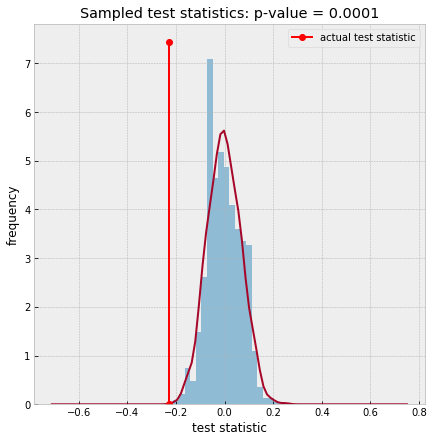

In [185]:
ax = plot_hist_with_kde_for_hypothesis_test(test_statistic_boot, p_val, left_ext=.5, right_ext=.5)
plt.show()

### Discrete observables - $n$-sided dice $p$s

Comparing fairness of dice using the $\chi^2$ test statistic

In [186]:
pop0_gen = stats.rv_discrete(values=(np.arange(5), [.2, .2, .2, .2, .2]))
pop1_gen = stats.rv_discrete(values=(np.arange(5), [.2, .25, .15, .2, .2]))

n0 = 1000
n1 = 120

samples0 = pop0_gen.rvs(size=n0)
samples1 = pop1_gen.rvs(size=n0)
samples0[:5], samples1[:5]

(array([4, 3, 0, 3, 0]), array([0, 0, 0, 3, 3]))

In [187]:
pd.Series(samples0).value_counts().sort_index()

0    220
1    215
2    183
3    209
4    173
dtype: int64

In [188]:
#export
def get_chi2_test_statistic(a:np.ndarray, b: np.ndarray) -> float: 
    "`b` is the reference"
    freq_e = pd.Series(b).value_counts(normalize=True).sort_index()
    freq_o = pd.Series(a).value_counts(normalize=True).sort_index()
    return ((freq_o - freq_e)**2/freq_e).sum()

In [189]:
test_statistic = get_chi2_test_statistic(samples1, samples0); test_statistic

0.007944368251113451

In [190]:
#hide
n_tests = 1000

In [191]:
%%time
test_statistic_boot = get_boot_test_statistics(samples1, samples0, n_tests=n_tests, 
                                               test_statistic_fun=get_chi2_test_statistic)

Wall time: 2.75 s


In [192]:
%%time
p_val = get_p_value(test_statistic_boot, test_statistic); p_val

Wall time: 0 ns


0.4166074247279987

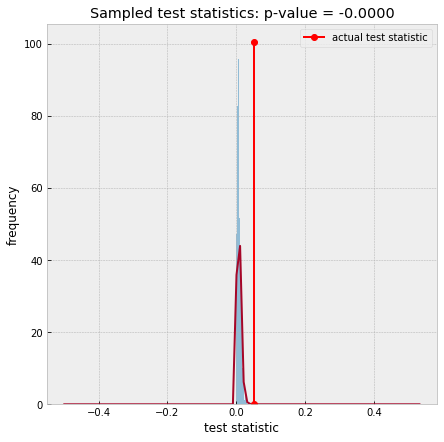

In [157]:
ax = plot_hist_with_kde_for_hypothesis_test(test_statistic_boot, p_val, left_ext=.5, right_ext=.5)
plt.show()

### Continuous - correlation

Testing how significant the ranked Spearman correlation of two variables is

In [193]:
x_noise = stats.norm(loc=0, scale=1.)
y_noise = stats.norm(loc=0, scale=1.)

n = 100

samples0 = np.linspace(-1,1,n) + x_noise.rvs(size=n)
samples1 = samples0 + y_noise.rvs(size=n)
samples0[:5], samples1[:5]

(array([-1.44618272, -2.17776027, -0.63076426, -0.05349711, -2.01605591]),
 array([-3.42547504, -2.42894734, -0.85560307, -0.04791731, -1.3396359 ]))

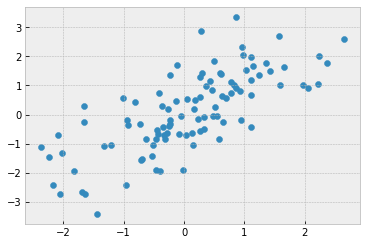

In [194]:
plt.scatter(samples0, samples1)
plt.show()

In [195]:
# export
def get_spearmanr_test_statistic(a:np.ndarray, b:np.ndarray) -> float:
    "Computes the ranked Spearman correlation"
    assert len(a) == len(b)
    return stats.spearmanr(a, b).correlation

In [196]:
test_statistic = get_spearmanr_test_statistic(samples1, samples0); test_statistic

0.773105310531053

In [197]:
#hide
n_tests = 1000

In [198]:
%%time
test_statistic_boot = get_boot_test_statistics(samples1, samples0, n_tests=n_tests, 
                                               test_statistic_fun=get_spearmanr_test_statistic)

Wall time: 551 ms


In [199]:
%%time
p_val = get_p_value(test_statistic_boot, test_statistic); p_val

Wall time: 0 ns


-4.440892098500626e-16

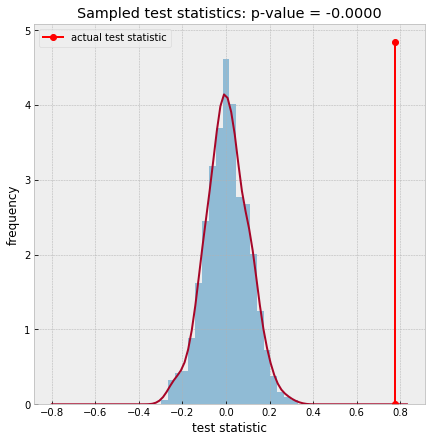

In [200]:
ax = plot_hist_with_kde_for_hypothesis_test(test_statistic_boot, p_val, left_ext=.5, right_ext=.5)
plt.show()

## NSFG data

Computing if the weight of newborns to first time mothers is significantly different to mothers with 1+ children using `get_mean_test_statistic`.

In [201]:
df = pd.read_csv(nsfg.clean_file_path)
df.head()

,caseid,prglngth,outcome,pregordr,birthord,birthwgt_lb,birthwgt_oz,agepreg,finalwgt,totalwgt_lb,totalwgt_kg
0,1,39,1,1,1.0,8.0,13.0,33.16,6448.271112,8.8125,3.997279
1,1,39,1,2,2.0,7.0,14.0,39.25,6448.271112,7.8750,3.572037
2,2,39,1,1,1.0,9.0,2.0,14.33,12999.542264,9.1250,4.139027
3,2,39,1,2,2.0,7.0,0.0,17.83,12999.542264,7.0000,3.175144
4,2,39,1,3,3.0,6.0,3.0,18.33,12999.542264,6.1875,2.806601


Grouping samples into first newborn (`first`) and 2nd or higher baby count (`other`)

In [70]:
live = df.loc[df["outcome"]==1, :]
first, other = live.loc[live["pregordr"]==1, :], live.loc[live["pregordr"]!=1, :]
len(first), len(other)

(3368, 5780)

Collecting the weights and cleaning

In [77]:
col = "totalwgt_kg"  # prglngth = pregnancy length, totalwgt_kg = total weight of the newborn
samples0, samples1 = first[col].dropna().values, other[col].dropna().values  

[3.9972795 4.139027  3.8838815 3.4302895 3.5436875] [3.572037  3.175144  2.8066005 4.3374735 3.798833 ]


-0.047628365605402845

Computing the test statistic over the original dataset

In [ ]:
test_statistic = get_mean_test_statistic(samples0, samples1); test_statistic

Mixing up the dataset computing test statistics

In [202]:
%%time
test_statistic_boot = get_boot_test_statistics(samples0, samples1, n_tests=n_tests)

Wall time: 26 ms


In [203]:
%%time
p_val = get_p_value(test_statistic_boot, test_statistic); p_val

Wall time: 1.03 ms


1.0136336214827679e-13

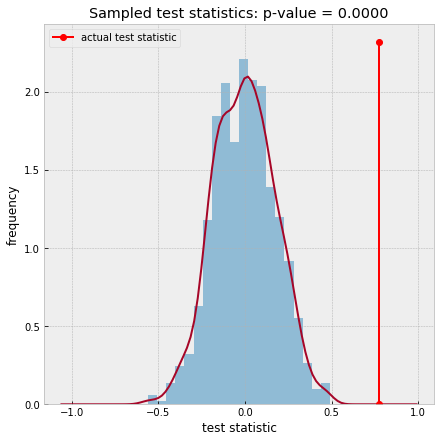

In [204]:
ax = plot_hist_with_kde_for_hypothesis_test(test_statistic_boot, p_val, left_ext=.5, right_ext=.5)
plt.show()